In [3]:
userID = 'adamranson'
expID = '2024-09-05_01_ESMT178'

In [5]:
%matplotlib widget
import pickle
import os
import organise_paths
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import shutil

import cv2
from io import BytesIO
import IPython.display as display
from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Label, Image as ImageWidget
import ipywidgets as widgets
from PIL import Image
import threading
from scipy.ndimage import median_filter

animalID, remote_repository_root, processed_root, exp_dir_processed, exp_dir_raw = organise_paths.find_paths(userID, expID)
exp_dir_processed_recordings = os.path.join(exp_dir_processed,'recordings')
exp_dir_processed_cut = os.path.join(exp_dir_processed,'cut')
video_path_left = os.path.join(exp_dir_processed,(expID+'_eye1_left.avi'))
video_path_right = os.path.join(exp_dir_processed,(expID+'_eye1_right.avi'))

# check if cropped videos are in the processed data directory and if not try to copy from the remote repos
# this can be removed in the future 
if not os.path.isfile(video_path_left):
    try:
        print('Copying eye videos - is is a one-off not required in future')
        shutil.copyfile(os.path.join(exp_dir_raw, (expID+'_eye1_left.avi')),video_path_left)
        shutil.copyfile(os.path.join(exp_dir_raw, (expID+'_eye1_right.avi')),video_path_right)
        print('Done!')
    except:
        print('Cropped eye videos not found on server')

# Check pupil

## Eye and pupil fits

In [6]:
global left_eyedat
with open(os.path.join(exp_dir_processed_recordings,'dlcEyeLeft.pickle'), "rb") as file: left_eyedat = pickle.load(file)

global right_eyedat
with open(os.path.join(exp_dir_processed_recordings,'dlcEyeRight.pickle'), "rb") as file: right_eyedat = pickle.load(file)
stop_flag = False

def overlay_plot(frame,position,eyeDat):
    # Check if the eyeDat has been fitted well, if not it contains nans
    if np.isnan(eyeDat['x'][position]) or np.isnan(eyeDat['y'][position]) or np.isnan(eyeDat['radius'][position]):
        # return frame with nothing plotted on it
        return frame

    color = (255, 0, 0)  # Red in BGR format
    thickness = 2
    x = eyeDat['eye_lid_x'][np.newaxis,position,:].T
    y = eyeDat['eye_lid_y'][np.newaxis,position,:].T
    points = np.concatenate([x,y],axis = 1)
    is_closed = False
    points = points.reshape((-1, 1, 2))  # Reshape points to the required format
    points = points.astype(int)
    frame = cv2.polylines(frame, [points], is_closed, color, thickness)

    # Draw a blue circle
    center = (50, 50)
    radius = 30
    color = (0, 0, 255)  # Blue in BGR format
    thickness = 2
    frame = cv2.circle(frame, [eyeDat['x'][position].astype(int),eyeDat['y'][position].astype(int)], eyeDat['radius'][position].astype(int), color, thickness)

    return frame

# this function is to play a single frame
def play_video(position, video_widget_L, video_widget_R):
    # update left video
    try:
        cap_L = cv2.VideoCapture(video_path_left)
        cap_L.set(cv2.CAP_PROP_POS_FRAMES, position)
        ret, frame = cap_L.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Overlay plot
            frame = overlay_plot(frame,position,left_eyedat)
            # # Display the frame
            img = Image.fromarray(frame)
            buffer = BytesIO()
            img.save(buffer, format='JPEG')
            video_widget_L.value = buffer.getvalue()

        # update right video
        cap_R = cv2.VideoCapture(video_path_right)
        cap_R.set(cv2.CAP_PROP_POS_FRAMES, position)
        ret, frame = cap_R.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Overlay plot
            frame = overlay_plot(frame,position,right_eyedat)
            # # Display the frame
            img = Image.fromarray(frame)
            buffer = BytesIO()
            img.save(buffer, format='JPEG')
            video_widget_R.value = buffer.getvalue()
    except:
        print('Error with overlay')
# Get total number of frames in the video
cap = cv2.VideoCapture(video_path_left)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
cap.release()

# Create slider
slider = widgets.IntSlider(min=0, max=total_frames-1, step=1, description='Position')

# Create play button
play_button = Button(description='Play')

# Create stop button
stop_button = Button(description='Stop')

# Create video widget
video_widget_L = ImageWidget()
video_widget_R = ImageWidget()

title1 = Label("Left eye")
title2 = Label("Right eye")

title1.style.font_size = '25px'
title1.layout.justify_content = 'center'
title2.style.font_size = '25px'
title2.layout.justify_content = 'center'

def playback_loop():
    global stop_flag
    position = slider.value
    while ((slider.value + 1) < total_frames) & (stop_flag == False):
        # advance slider
        slider.value = slider.value + 1
        play_video(slider.value, video_widget_L,video_widget_R)
        # time.sleep(0.033)

def on_play_button_click(_):
    global stop_flag
    stop_flag = False
    playback_thread = threading.Thread(target=playback_loop)
    playback_thread.start()

def on_stop_button_click(_):
    global stop_flag
    stop_flag = True

def on_slider_change(change):
    if change['name'] == 'value':
        play_video(change['new'], video_widget_L, video_widget_R)

play_button.on_click(on_play_button_click)
stop_button.on_click(on_stop_button_click)
slider.observe(on_slider_change, names='value')

# Create layout
layout = HBox([slider, play_button, stop_button])

# Create vertical Box layouts for each ImageWidget and title
widgets_box1 = VBox([title1, video_widget_L])
widgets_box2 = VBox([title2, video_widget_R])

# Display ImageWidgets with titles side by side using a horizontal Box layout
widgets_box = HBox([widgets_box1, widgets_box2])

# Display the controls and video
display.display(layout)
display.display(widgets_box)

# interact_manual(lambda position: play_video(position, video_widget), position=slider)
play_video(slider.value,video_widget_L,video_widget_R)


## Pupil properties vs time

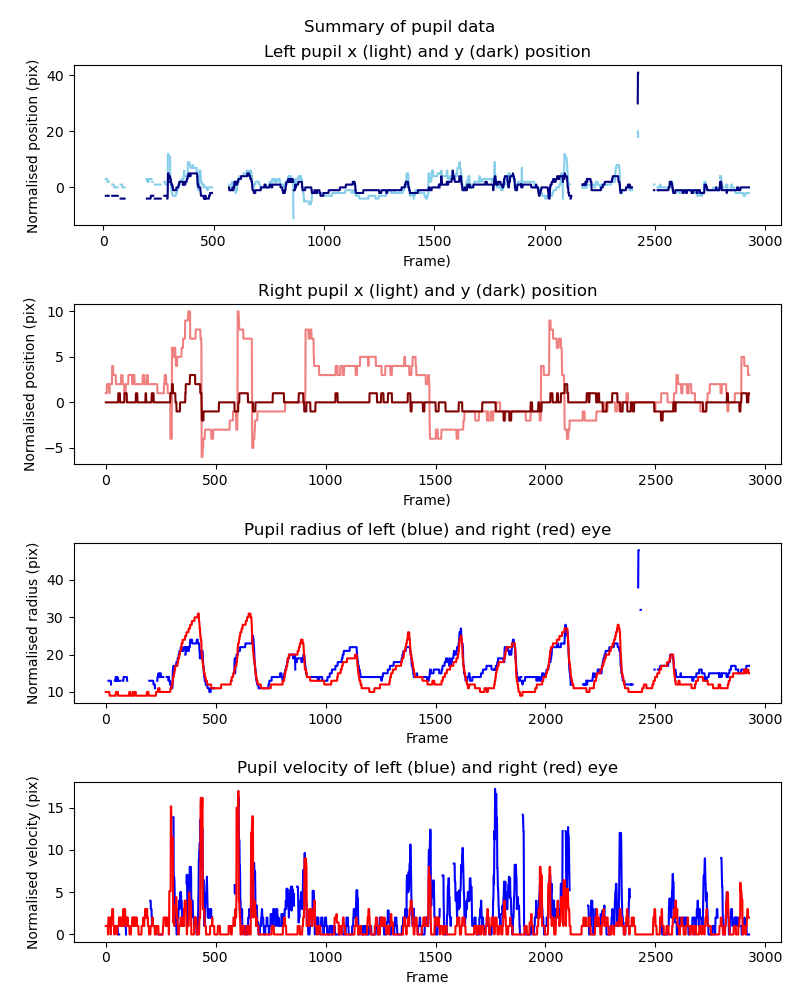

In [ ]:
with open(os.path.join(exp_dir_processed_recordings,'dlcEyeLeft.pickle'), "rb") as file: left_dlc = pickle.load(file)
with open(os.path.join(exp_dir_processed_recordings,'dlcEyeRight.pickle'), "rb") as file: right_dlc = pickle.load(file)
# Create a 3-row subplot to plot pupil position, radius and velocity
fig, axs = plt.subplots(4, 1, figsize=(8, 10))
# Plot data on each subplot
axs[0].plot(left_dlc['x']-np.nanmedian(left_dlc['x']), color = 'skyblue')
axs[0].plot(left_dlc['y']-np.nanmedian(left_dlc['y']), color = 'navy')
axs[0].set_title('Left pupil x (light) and y (dark) position')
axs[0].set_xlabel('Frame)')
axs[0].set_ylabel('Normalised position (pix)')

axs[1].plot(right_dlc['x']-np.nanmedian(right_dlc['x']), color = 'lightcoral')
axs[1].plot(right_dlc['y']-np.nanmedian(right_dlc['y']), color = 'maroon')
axs[1].set_title('Right pupil x (light) and y (dark) position')
axs[1].set_xlabel('Frame)')
axs[1].set_ylabel('Normalised position (pix)')

axs[2].plot(left_dlc['radius'], color = 'blue')
axs[2].plot(right_dlc['radius'], color = 'red')
axs[2].set_title('Pupil radius of left (blue) and right (red) eye')
axs[2].set_xlabel('Frame')
axs[2].set_ylabel('Normalised radius (pix)')

axs[3].plot(left_dlc['velocity'], color = 'blue')
axs[3].plot(right_dlc['velocity'], color = 'red')
axs[3].set_title('Pupil velocity of left (blue) and right (red) eye')
axs[3].set_xlabel('Frame')
axs[3].set_ylabel('Normalised velocity (pix)')
# Add overall title and adjust spacing
fig.suptitle('Summary of pupil data')
fig.tight_layout()
# Show the plot
plt.show()